In [21]:
import utils 
import transformer 
import bar_distribution
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import prior 
matplotlib.use('TkAgg')
%matplotlib inline
import main
import importlib
device = torch.device("cuda")
importlib.reload(utils)
importlib.reload(transformer)
importlib.reload(bar_distribution)
importlib.reload(main)
importlib.reload(prior)
import random
#####################################################################################################################################################
import warnings 
warnings.filterwarnings("ignore")

In [23]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
seq_len = 200
num_epochs = 1000
lr = 0.001
num_outputs = 5
batch_size = 500
in_features = 2
noise = False
warm_up_epochs = 5
std_variation=True
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
#criterion = bar_distribution.FullSupportBarDistribution(bar_distribution.get_bucket_limits(num_outputs=num_outputs,ys=y))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = utils.get_cosine_schedule_with_warmup(optimizer, warm_up_epochs, num_epochs)
model.criterion = criterion

Using device: Quadro P1000
total params:2111493


In [24]:
%matplotlib inline
trains= main.train(model, criterion, num_epochs, optimizer, scheduler, batch_size, seq_len, in_features, num_classes=num_outputs,std_variation=std_variation)

| epoch   0 | lr 0.0002 || loss 1.796
| epoch  50 | lr 0.0009947356387190894 || loss 0.876
| epoch 100 | lr 0.000977206634636375 || loss 0.646
| epoch 150 | lr 0.0009478090741310872 || loss 0.454
| epoch 200 | lr 0.0009072741008634748 || loss 0.390
| epoch 250 | lr 0.0008566098559246207 || loss 0.387
| epoch 300 | lr 0.000797076404464545 || loss 0.392
| epoch 350 | lr 0.0007301543967433242 || loss 0.322
| epoch 400 | lr 0.0006575082430329493 || loss 0.345
| epoch 450 | lr 0.000580944718243102 || loss 0.403
| epoch 500 | lr 0.0005023680258108777 || loss 0.273
| epoch 550 | lr 0.0004237324384557698 || loss 0.247
| epoch 600 | lr 0.00034699369366675384 || loss 0.232
| epoch 650 | lr 0.0002740603527592437 || loss 0.223
| epoch 700 | lr 0.00020674633324573827 || loss 0.348
| epoch 750 | lr 0.00014672579508261618 || loss 0.249
| epoch 800 | lr 9.549150281252633e-05 || loss 0.280
| epoch 850 | lr 5.43176991731909e-05 || loss 0.265
| epoch 900 | lr 2.4228413539217843e-05 || loss 0.227
| epoch 

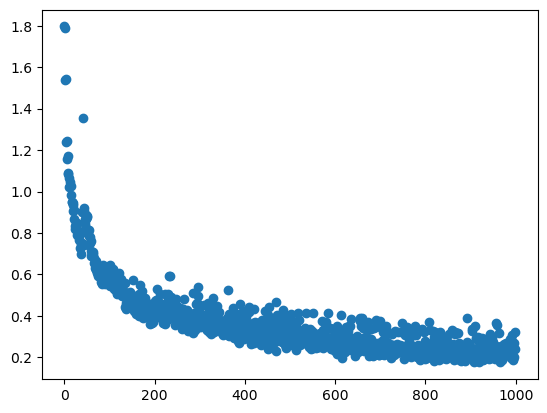

In [25]:
%matplotlib inline
plt.scatter(np.arange(num_epochs), trains, label="training loss")
plt.show()

In [52]:
%matplotlib inline
temp_batch_size = 10
seq_len = 100
train_X, train_Y, y_target, batch_classes = prior.sample_clusters(batch_size=temp_batch_size,seq_len=seq_len,
                                                                  num_classes=num_outputs, kmeans=True,std_variation = std_variation) 
model.eval()
num_points = seq_len

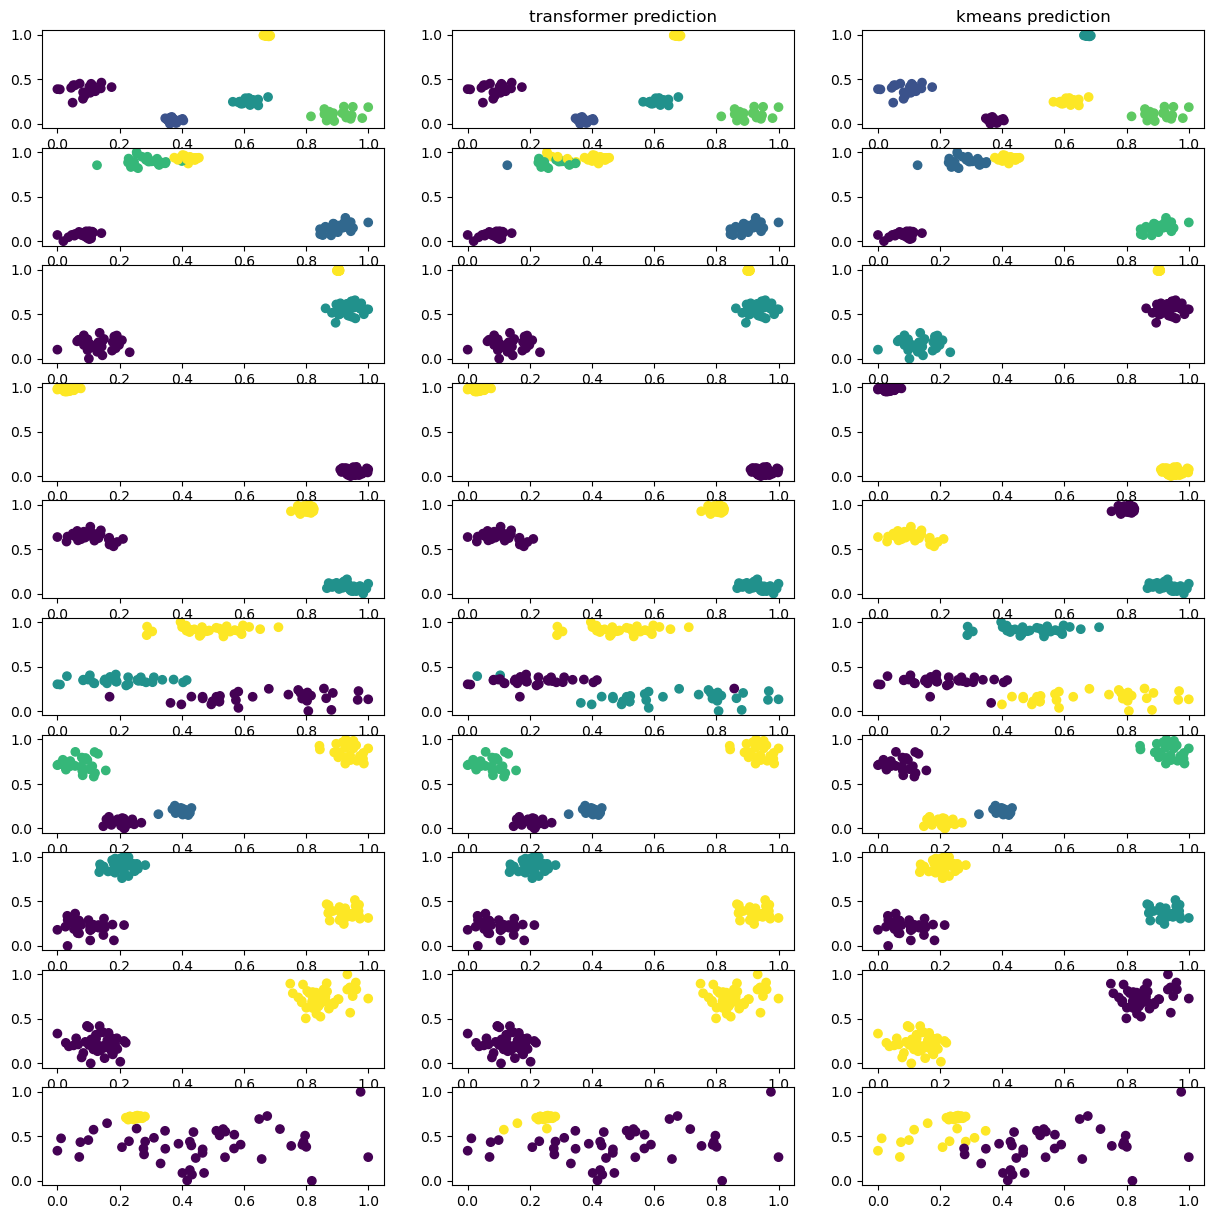

In [53]:
train_x = train_X[:num_points]
X_total = torch.cat((train_x, train_X), dim=0) 
# # Set up grid for subplots
fig, axes = plt.subplots(temp_batch_size, 3, figsize=(15, 15)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    train_x = train_X[:, batch_index]
    train_y = train_Y[:, batch_index] 
    axes[3 * batch_index].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=train_y.cpu().numpy())
    logits = model(X_total[:, batch_index], num_points)
    k_labels = utils.k_means(train_x, batch_classes[batch_index])
    predictions = torch.argmax(logits, dim=1)
    axes[3 * batch_index +1].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=predictions.cpu().numpy())
    axes[3 * batch_index +2].scatter(train_x[:, 0].cpu().numpy() , train_x[:, 1].cpu().numpy() , c=k_labels)
axes[1].set_title(f"transformer prediction")
axes[2].set_title(f"kmeans prediction")
plt.show()